# GAN - Generative Adversarial Network

## Importing the libraries and dependencies and drive
The following cell block imports all the libraries, functions, methods that are being used inn this jupyter notebook.<br>
The Deep Learning/Machine Learning Libarary being used here is the high level keras API of tensorflow 2.X.<Br>
And the plotting is done with matplotlib or seaborn plotting packages.

Along with this all the constants that will be common throughout the file are defined and declared here.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import random, math, os, pickle, random, librosa
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from itertools import combinations
%matplotlib inline

EPOCHS = 200
BATCH_SIZE = 128
IMG_SIZE = (28,28)
SEED = 100
CLASSES = 10
LEARNING_RATE = 0.001
ACCURACY_THRESHOLD = 0.98

## Loading Data
The following block of code loads MNIST data in two formats.
- First is through the dataset module from keras which loads data in numpy arrays.
- Second is the TFDS - Tensorflow dataset module which loads data in the format of tenorflow_dataset whic makes it fast o process and load data onto and away from the memory(GPU/CPU)

I experimented with both the above techniques but the second one was very fast and thats what i am sticking with.
As it loads the next batch of data onto GPU memory while the current batch is being operated on - this is done with the prefetching functionality of the tensirflow_dataset module.

In [2]:
# df_train, df_test = tf.keras.datasets.mnist.load_data()

(df_train, df_test), df_info = tfds.load(
    'mnist',
    split=['train', 'test'],
    shuffle_files = False,
    with_info = True,
    as_supervised = True
)

local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead pass
`try_gcs=True` to `tfds.load` or set `data_dir=gs://tfds-data/datasets`.



Dl Completed...:   0%|          | 0/4 [00:00<?, ? file/s]


Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


In [3]:
df_info

tfds.core.DatasetInfo(
    name='mnist',
    version=3.0.1,
    description='The MNIST database of handwritten digits.',
    homepage='http://yann.lecun.com/exdb/mnist/',
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
    }),
    total_num_examples=70000,
    splits={
        'test': 10000,
        'train': 60000,
    },
    supervised_keys=('image', 'label'),
    citation="""@article{lecun2010mnist,
      title={MNIST handwritten digit database},
      author={LeCun, Yann and Cortes, Corinna and Burges, CJ},
      journal={ATT Labs [Online]. Available: http://yann.lecun.com/exdb/mnist},
      volume={2},
      year={2010}
    }""",
    redistribution_info=,
)

## Labels for the data & Look at the data

In [26]:
(train_imgs, train_labels), (test_imgs, test_labels) = tf.keras.datasets.mnist.load_data()
train_imgs = train_imgs.reshape((-1,train_imgs.shape[1]*train_imgs.shape[2]))
test_imgs = test_imgs.reshape((-1,test_imgs.shape[1]*test_imgs.shape[2]))
train_imgs = 2*((train_imgs/255.)-0.5)
test_imgs = 2*((test_imgs/255.)-0.5)

In [4]:
{df_info.features['label'].str2int(x):x for x in df_info.features['label'].names}

{0: '0',
 1: '1',
 2: '2',
 3: '3',
 4: '4',
 5: '5',
 6: '6',
 7: '7',
 8: '8',
 9: '9'}

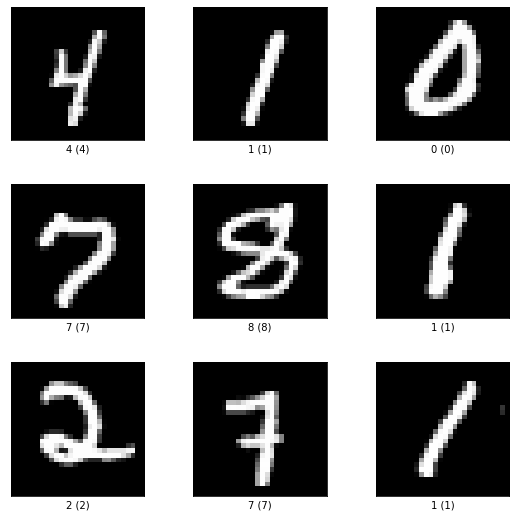

In [5]:
fig = tfds.show_examples(df_train, df_info)

## Model Architecture, Custom fnction & Training

In [30]:
def build_discriminator(random_vec_size = 100, img_size = 784, num_labels = 10):
    decoder_inp = tf.keras.layers.Input(shape = (img_size + num_labels))

    # Discriminator - Decoder
    de_layer = tf.keras.layers.Dense(794, activation = 'relu', kernel_initializer='HeNormal')(decoder_inp)
    de_layer = tf.keras.layers.Dropout(0.2)(de_layer)
    de_layer = tf.keras.layers.Dense(400, activation = 'relu', kernel_initializer='HeNormal')(de_layer)
    de_layer = tf.keras.layers.Dropout(0.2)(de_layer)
    de_layer = tf.keras.layers.Dense(200, activation = 'relu', kernel_initializer='HeNormal')(de_layer)
    de_layer = tf.keras.layers.Dropout(0.2)(de_layer)
    de_layer = tf.keras.layers.Dense(100, activation = 'relu', kernel_initializer='HeNormal')(de_layer)
    de_layer_out = tf.keras.layers.Dense(1, activation='sigmoid')(de_layer)

    decoder = tf.keras.models.Model(inputs = decoder_inp, outputs = de_layer_out)
    decoder.compile(loss = 'binary_crossentropy',
                    optimizer = tf.keras.optimizers.Adam(0.00005, 0.5), 
                    metrics=['accuracy'])
    return decoder

def build_generator(random_vec_size = 100, img_size = 784, num_labels = 10):
    encoder_inp = tf.keras.layers.Input(shape = (random_vec_size + num_labels))

    # Generator - Encoder
    en_layer = tf.keras.layers.Dense(110, activation = 'relu',kernel_initializer='HeNormal')(encoder_inp)
    en_layer = tf.keras.layers.Dense(200, activation = 'relu',kernel_initializer='HeNormal')(en_layer)
    en_layer = tf.keras.layers.Dense(400, activation = 'relu',kernel_initializer='HeNormal')(en_layer)
    en_layer_out = tf.keras.layers.Dense(784, activation = 'tanh')(en_layer)

    encoder = tf.keras.models.Model(inputs = encoder_inp, outputs = en_layer_out)
    # encoder.compile(loss = 'binary_crossentropy',
    #                 optimizer = tf.keras.optimizers.Adam(0.0002, 0.5), 
    #                 metrics=['accuracy'])

    return encoder

def build_gan(generator, discriminator, latent_dim = 100):
    rand_data = tf.keras.layers.Input(shape=(latent_dim,))
    one_hot_labels = tf.keras.layers.Input(shape=(10,))

    gen_inp = tf.keras.layers.concatenate([rand_data, one_hot_labels])
    features = generator(gen_inp)

    dis_inp = tf.keras.layers.concatenate([features, one_hot_labels])
    output = discriminator(dis_inp)
    
    discriminator.trainable = False
    
    model = tf.keras.models.Model([rand_data, one_hot_labels], outputs = output)
    model.compile(loss='binary_crossentropy', 
                  optimizer=tf.keras.optimizers.Adam(0.0005, 0.5), 
                  metrics=['accuracy'])
    return model

def get_random_batch(imgs, lbls, idx, batch_size = 100):

    imgs_batch = imgs[idx:idx+batch_size]
    lbls_batch = np.eye(10)[lbls[idx:idx+batch_size]]
    
    return imgs_batch, lbls_batch 

discriminator = build_discriminator()
generator = build_generator()
gan = build_gan(generator, discriminator)

def train(epochs=100, batch_size=100, latent_dim = 100):
    real_accs, fake_accs = [], []
    gen_losses, d_losses = [], []

    for epoch in range(epochs):
        epoch_real_acc, epoch_fake_acc = [], []
        epoch_gen_losses, epoch_d_losses = [], []

        for i in range(0,len(train_imgs),
                       batch_size):
            discriminator.trainable = True
            
            img, labels = get_random_batch(train_imgs, train_labels, i)
            real_dis_loss, real_dis_acc = discriminator.train_on_batch(np.concatenate([img, labels], axis=1), 
                                                                              np.ones(shape= (batch_size, 1)))
            epoch_real_acc.append(real_dis_acc)

            z = np.random.normal(size = (batch_size, latent_dim))
            fake_labels = np.eye(10)[np.random.choice(10, batch_size,replace=True)]
            gen_img = generator.predict(np.concatenate([z,fake_labels], axis=1))
            fake_dis_loss, fake_dis_acc = discriminator.train_on_batch(np.concatenate([gen_img, fake_labels], axis=1), 
                                                                              np.zeros(shape = (batch_size,1)))
            epoch_fake_acc.append(fake_dis_acc)

            d_loss=(real_dis_loss + fake_dis_loss)/2
            epoch_d_losses.append(d_loss)

            discriminator.trainable = False
            z = np.random.normal(0,1,size = (batch_size, latent_dim))
            labels = np.eye(10)[np.random.choice(10, batch_size,replace=True)]
            g_loss = gan.train_on_batch([z,labels], 
                                        np.ones(shape= (batch_size, 1)))
            epoch_gen_losses.append(g_loss)
            
        
        epoch_real_accuracy = np.mean(epoch_real_acc)
        epoch_fake_accuracy = np.mean(epoch_fake_acc)
        epoch_gen_loss = np.mean(epoch_gen_losses)
        epoch_d_loss = np.mean(epoch_d_losses)

        real_accs.append(epoch_real_accuracy)
        fake_accs.append(epoch_fake_accuracy)
        gen_losses.append(epoch_gen_loss)
        d_losses.append(epoch_d_loss)
        print(f"Epoch : {epoch} Discriminator Loss : {round(epoch_d_loss, 4)}",
              f"Real Img Acc : {round(epoch_real_accuracy, 4)} Fake Img Acc : {round(epoch_fake_accuracy, 4)}",
              f"Generator Loss : {round(epoch_gen_loss, 4)}")

    return (real_accs,fake_accs,gen_losses,d_losses)

history=train()

Epoch : 0 Discriminator Loss : 0.7913 Real Img Acc : 0.627 Fake Img Acc : 0.2673 Generator Loss : 0.6399
Epoch : 1 Discriminator Loss : 0.7269 Real Img Acc : 0.592 Fake Img Acc : 0.3293 Generator Loss : 0.6378
Epoch : 2 Discriminator Loss : 0.7055 Real Img Acc : 0.646 Fake Img Acc : 0.3302 Generator Loss : 0.6337
Epoch : 3 Discriminator Loss : 0.6979 Real Img Acc : 0.6554 Fake Img Acc : 0.3449 Generator Loss : 0.6203
Epoch : 4 Discriminator Loss : 0.6884 Real Img Acc : 0.6717 Fake Img Acc : 0.3647 Generator Loss : 0.6018
Epoch : 5 Discriminator Loss : 0.6838 Real Img Acc : 0.657 Fake Img Acc : 0.3946 Generator Loss : 0.5988
Epoch : 6 Discriminator Loss : 0.6801 Real Img Acc : 0.6478 Fake Img Acc : 0.4172 Generator Loss : 0.5891
Epoch : 7 Discriminator Loss : 0.6705 Real Img Acc : 0.6481 Fake Img Acc : 0.4536 Generator Loss : 0.5813
Epoch : 8 Discriminator Loss : 0.6634 Real Img Acc : 0.6143 Fake Img Acc : 0.52 Generator Loss : 0.5621
Epoch : 9 Discriminator Loss : 0.6643 Real Img Acc :

Training was only done for 100 epochs because it took around 3 hours to train the above question 3 code (even on colab pro).

## Plotting the accuracies

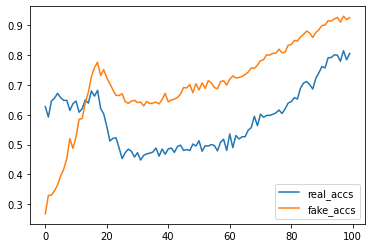

In [47]:
plt.plot(history[0], label='real_accs')
plt.plot(history[1], label = 'fake_accs')
plt.legend(loc="lower right")
plt.show()

## Plotting the OUtput

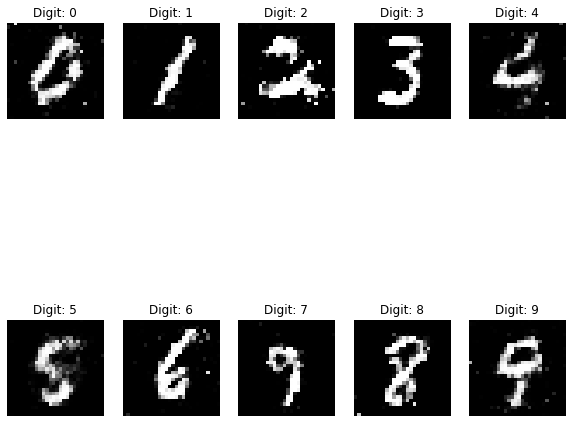

In [34]:
gen_image = 0.5 * generator.predict(np.concatenate([np.random.normal(0,1,(10, 100)),
                                              np.eye(10)], axis=1)) + 0.5
    
fig, axes = plt.subplots(2, 5, figsize = (10,10))
count = 0
for i in range(2):
    for j in range(5):
        axes[i,j].imshow(gen_image[count,:].reshape((28,28)),cmap = 'gray')
        axes[i,j].axis('off')
        axes[i,j].set_title("Digit: %d" % np.argmax(labels[count,:]))
        count+=1
  

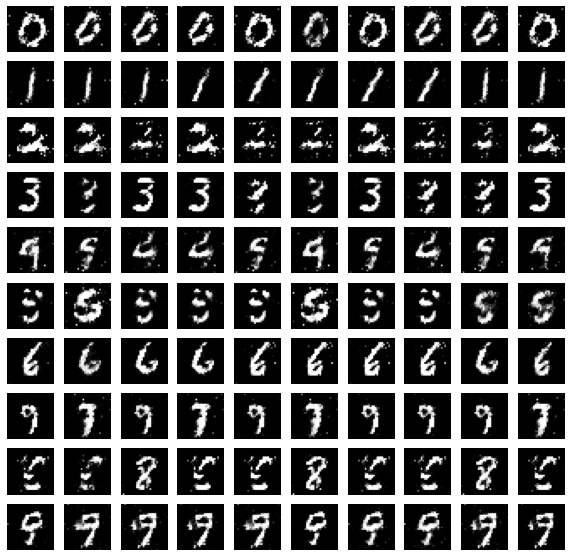

In [33]:
def plot_images(mod):
    plt.figure(figsize=(10, 10))
    for i in range(10):
        for j in range(10):
            ax=plt.subplot2grid((10, 10), (i, j))
            z = np.random.normal(0,1,(1, 100))
            label = np.zeros(shape = (1, 10))
            label[0,i] = 1
            gen_image = mod.predict(np.concatenate([z, label], axis=1))
            gen_image = 0.5*gen_image + 0.5
            try:
                ax.imshow(gen_image.reshape((28,28)), cmap='gray')
            except:
                pass
            plt.axis('off')
    plt.show()

plot_images(generator)